In [1]:
#config consts
IMG_SIZE='512x512'
IMAGE_SIZE = [512, 512]
SPLIT_RATE=0.95
LABEL_SMOOTH_FACTOR = 0.05
FOLD=2
EPOCHS = 15
EXPERIMENT='effb0_fold_2'
INPUT_DIR ='/content/drive/My Drive/kaggle/melanoma/input/'
OUTPUT_DIR = '/content/drive/My Drive/kaggle/melanoma/output/'
IMPORT_DIR = '/content/drive/My Drive/kaggle/melanoma/nbs/'
EXPERIMENT_DIR = OUTPUT_DIR + EXPERIMENT+'/'
CHKP_DIR = EXPERIMENT_DIR+'chkp/'
OUTPUT_SUBDIR = ''
TRAIN_FOLDS_FILE = 'folds_08062020.csv'
TEST_CSV_FILE = 'test.csv'
SAMPLE_SUBMISSION_FILE = 'sample_submission.csv'
MARKING_FILE = 'marking.csv'
LOG_FILE = EXPERIMENT_DIR+'log_'+EXPERIMENT+'.csv'

#GCS_SHON_PATH = KaggleDatasets().get_gcs_path('melanoma-merged-external-data-512x512-jpeg')
#GCS_SHON_PATH='gs://kds-63b9a60ae49cfb3095f25ef8af72d5114625af20d095ff5962c449df' #20.06.2020
GCS_SHON_PATH='gs://kds-3696481688d4fd8f51534bb5cc1dab7eff71b487b05177a984740303' #21.06.2020

#lr sheduler consts
LR_MAX = 0.001
LR_MIN = 0.00001
T_MAX = 100

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install -q efficientnet 

In [4]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-yee7b0ia
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-yee7b0ia
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20032 sha256=fb69722609f2b89bfb00f69b97981d7f0fc3e0d5aaa4a149ac802fc8f956c5da
  Stored in directory: /tmp/pip-ephem-wheel-cache-yenmp1t7/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [5]:
import os
import re
import errno


import numpy as np
import pandas as pd
import math
import PIL
import gc
import time
import datetime
import cv2 

from matplotlib import pyplot as plt
from PIL import Image

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback

import efficientnet.tfkeras as efn

from classification_models.tfkeras import Classifiers

In [6]:
try:
  os.mkdir(EXPERIMENT_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(EXPERIMENT_DIR+' already exists')
    else:
        raise

try:
  os.mkdir(CHKP_DIR)
except OSError as e:
    if e.errno == errno.EEXIST:
        print(CHKP_DIR+' already exists')
    else:
        raise

/content/drive/My Drive/kaggle/melanoma/output/effb0_fold_2/ already exists
/content/drive/My Drive/kaggle/melanoma/output/effb0_fold_2/chkp/ already exists


In [7]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.124.167.202:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.124.167.202:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.167.202:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE


BATCH_SIZE = 8 * strategy.num_replicas_in_sync
TRAINING_SHON_FILENAMES = tf.io.gfile.glob(GCS_SHON_PATH+'/*dataset*/*dataset*/*.jpg')
TEST_SHON_FILENAMES = tf.io.gfile.glob(GCS_SHON_PATH + '/*test*/*test*/*.jpg')
test = pd.read_csv(INPUT_DIR+TEST_CSV_FILE)
train_folds = pd.read_csv(INPUT_DIR+TRAIN_FOLDS_FILE)
marking = pd.read_csv(INPUT_DIR+MARKING_FILE)
sub = pd.read_csv(INPUT_DIR+SAMPLE_SUBMISSION_FILE)

train_fold_0 = train_folds[train_folds['fold']!=FOLD]
val_fold_0  =  train_folds[train_folds['fold']==FOLD]

def format_path_train(img_name):
    return GCS_SHON_PATH + '/512x512-dataset-melanoma/512x512-dataset-melanoma/' + img_name + '.jpg'

def format_path_test(img_name):
    return GCS_SHON_PATH + '/512x512-test/512x512-test/' + img_name + '.jpg'

train_paths_fold_0 = train_fold_0.image_id.apply(format_path_train).values
val_paths_fold_0 = val_fold_0.image_id.apply(format_path_train).values

train_labels_fold_0 = train_fold_0.target.values
val_labels_fold_0 = val_fold_0.target.values

test_paths = test.image_name.apply(format_path_test).values

In [19]:
print('all labeled:',len(TRAINING_SHON_FILENAMES), 
      '\ntest: ', len(TEST_SHON_FILENAMES),
      '\ntrainfold set: ', len(train_fold_0), 
      '\nvalid set:', len(val_fold_0))

all labeled: 60487 
test:  10982 
trainfold set:  46797 
valid set: 11660


In [ ]:
def cutmix(image, label, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = IMAGE_SIZE[0]
    #CLASSES = 1
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = label[j]
            lab2 = label[k]
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,1))
    return image2,label2

In [ ]:
def mixup(image, label, PROBABILITY = 1.0, alpha=0.4):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    DIM = IMAGE_SIZE[0]

    #CLASSES = 1
    
    imgs = []; labs = []
    for j in range(AUG_BATCH):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,AUG_BATCH),tf.int32)
        r1 = tf.random.gamma(shape=[],alpha=alpha, beta=1.0)
        r2 = tf.random.gamma(shape=[],alpha=alpha, beta=1.0)
        a = r1 / (r1 + r2) * P
        #a = tf.random.gamma(shape=[],alpha=0.4,beta=0.4)*P # this is beta dist with alpha=4.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        # MAKE CUTMIX LABEL
        if len(label.shape)==1:
            lab1 = label[j]
            lab2 = label[k]
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(AUG_BATCH,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(AUG_BATCH,1))
    return image2,label2

In [ ]:
def batch_mixup(images, labels, PROBABILITY=1.0, alpha=0.4, batch_size=0):

    DIM = IMAGE_SIZE[0]
    #CLASSES = 104
    
    if batch_size == 0:
        batch_size = BATCH_SIZE
    
    # Do `batch_mixup` with a probability = `PROBABILITY`
    # This is a tensor containing 0 or 1 -- 0: no mixup.
    # shape = [batch_size]
    do_mixup = tf.cast(tf.random.uniform([batch_size], 0, 1) <= PROBABILITY, tf.int32)

    # Choose random images in the batch for cutmix
    # shape = [batch_size]
    new_image_indices = tf.cast(tf.random.uniform([batch_size], 0, batch_size), tf.int32)
    
    # ratio of importance of the 2 images to be mixed up
    # shape = [batch_size]

    r1 = tf.random.gamma(shape=[batch_size],alpha=alpha, beta=1.0)
    r2 = tf.random.gamma(shape=[batch_size],alpha=alpha, beta=1.0)
    a = tf.math.divide(r1 , (r1 + r2)) * tf.cast(do_mixup, tf.float32)

    #a = tf.random.uniform([batch_size], 0, 1) * tf.cast(do_mixup, tf.float32)  # this is beta dist with alpha=1.0
                
    # The second part corresponds to the images to be added to the original images `images`.
    new_images =  (1-a)[:, tf.newaxis, tf.newaxis, tf.newaxis] * images + a[:, tf.newaxis, tf.newaxis, tf.newaxis] * tf.gather(images, new_image_indices)

    # Make labels
    #if len(labels.shape) == 1:
    #   labels = tf.one_hot(labels,1)

    new_labels =  (1-a)* labels + a * tf.gather(labels, new_image_indices)

    return new_images, new_labels

In [ ]:
def get_batch_rotation_matrix(angles, batch_size=0):
    """Returns a tf.Tensor of shape (batch_size, 3, 3) with each element along the 1st axis being
       an image rotation matrix (which transforms indicies).

    Args:
        angles: 1-D Tensor with shape [batch_size].
        
    Returns:
        A 3-D Tensor with shape [batch_size, 3, 3].
    """    

    if batch_size == 0:
        batch_size = BATCH_SIZE
    
    # CONVERT DEGREES TO RADIANS
    angles = tf.constant(math.pi) * angles / 180.0

    # shape = (batch_size,)
    one = tf.ones_like(angles, dtype=tf.float32)
    zero = tf.zeros_like(angles, dtype=tf.float32)
    
    # ROTATION MATRIX
    c1 = tf.math.cos(angles) # shape = (batch_size,)
    s1 = tf.math.sin(angles) # shape = (batch_size,)

    # Intermediate matrix for rotation, shape = (9, batch_size) 
    rotation_matrix_temp = tf.stack([c1, s1, zero, -s1, c1, zero, zero, zero, one], axis=0)
    # shape = (batch_size, 9)
    rotation_matrix_temp = tf.transpose(rotation_matrix_temp)
    # Fianl rotation matrix, shape = (batch_size, 3, 3)
    rotation_matrix = tf.reshape(rotation_matrix_temp, shape=(batch_size, 3, 3))
        
    return rotation_matrix


def batch_random_rotate(images, max_angles, batch_size=0):
    """Returns a tf.Tensor of the same shape as `images`, represented a batch of randomly transformed images.

    Args:
        images: 4-D Tensor with shape (batch_size, width, hight, depth).
            Currently, `depth` can only be 3.
        
    Returns:
        A 4-D Tensor with the same shape as `images`.
    """ 
    
    # input `images`: a batch of images [batch_size, dim, dim, 3]
    # output: images randomly rotated, sheared, zoomed, and shifted
    DIM = images.shape[1]
    XDIM = DIM % 2  # fix for size 331
    
    if batch_size == 0:
        batch_size = BATCH_SIZE
    
    angles = max_angles * tf.random.normal([batch_size], dtype='float32')

  
    # GET TRANSFORMATION MATRIX
    # shape = (batch_size, 3, 3)
    m = get_batch_rotation_matrix(angles, batch_size) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat(tf.range(DIM // 2, -DIM // 2, -1), DIM)  # shape = (DIM * DIM,)
    y = tf.tile(tf.range(-DIM // 2, DIM // 2), [DIM])  # shape = (DIM * DIM,)
    z = tf.ones([DIM * DIM], dtype='int32')  # shape = (DIM * DIM,)
    idx = tf.stack([x, y, z])  # shape = (3, DIM * DIM)
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = tf.linalg.matmul(m, tf.cast(idx, dtype='float32'))  # shape = (batch_size, 3, DIM ** 2)
    idx2 = K.cast(idx2, dtype='int32')  # shape = (batch_size, 3, DIM ** 2)
    idx2 = K.clip(idx2, -DIM // 2 + XDIM + 1, DIM // 2)  # shape = (batch_size, 3, DIM ** 2)
    
    # FIND ORIGIN PIXEL VALUES
    # shape = (batch_size, 2, DIM ** 2)
    idx3 = tf.stack([DIM // 2 - idx2[:, 0, ], DIM // 2 - 1 + idx2[:, 1, ]], axis=1)  
    
    # shape = (batch_size, DIM ** 2, 3)
    d = tf.gather_nd(images, tf.transpose(idx3, perm=[0, 2, 1]), batch_dims=1)
        
    # shape = (batch_size, DIM, DIM, 3)
    new_images = tf.reshape(d, (batch_size, DIM, DIM, 3))

    return new_images


def batch_get_grid_mask(d1, d2, ratio=0.5, max_angle=90, batch_size=0):
        
    # ratio: the ratio of black region

    DIM = IMAGE_SIZE[0]
    #CLASSES = 104
    
    if batch_size == 0:
        batch_size = BATCH_SIZE

    # Length of diagonal
    hh = tf.cast((tf.math.ceil(tf.math.sqrt(2.0) * DIM)), tf.int64)
    hh = hh + tf.math.floormod(hh, 2)
    
    # We look squares of size dxd inside each image
    d = tf.random.uniform(shape=[], minval=d1, maxval=d2, dtype=tf.int64)
    
    # Inside each square of size dxd, we mask a square of size LxL (L <= d)
    l = tf.cast(tf.cast(d, tf.float32) * ratio + 0.5, tf.int64)

    lower_limit = -1
    upper_limit = tf.math.floordiv(hh, d) + 1
    indices = tf.range(lower_limit, upper_limit)  # shape = [upper_limit + 1]
    
    # The 1st component has shape [upper_limit + 1, 1]
    # The 2nd component has shae [1: L]
    # The addition has shape [upper_limit + 1: L]
    # The final output has sahpe [upper_limit + 1 * L]
    ranges = tf.reshape((d * indices)[:, tf.newaxis] + tf.range(l, dtype=tf.int64)[tf.newaxis, :], shape=[-1])
    shift = tf.random.uniform(shape=[], minval=0, maxval=d, dtype=tf.int64)
    
    ranges = shift + ranges

    clip_mask = tf.logical_or(ranges < 0 , ranges > hh - 1)
    ranges = tf.boolean_mask(ranges, tf.logical_not(clip_mask))

    hh_ranges = tf.tile(tf.range(0,hh), [tf.cast(tf.reduce_sum(tf.ones_like(ranges)), tf.int64)])
    
    ranges = tf.repeat(ranges, hh)

    y_hh_indices = tf.transpose(tf.stack([ranges, hh_ranges]))
    x_hh_indices = tf.transpose(tf.stack([hh_ranges, ranges]))

    y_mask_sparse = tf.SparseTensor(tf.cast(y_hh_indices, tf.int64),  tf.zeros_like(ranges), [hh, hh])
    y_mask = tf.sparse.to_dense(y_mask_sparse, 1, False)

    x_mask_sparse = tf.SparseTensor(tf.cast(x_hh_indices, tf.int64), tf.zeros_like(ranges), [hh, hh])
    x_mask = tf.sparse.to_dense(x_mask_sparse, 1, False)
    
    mask = tf.expand_dims( tf.clip_by_value(x_mask + y_mask, 0, 1), axis=-1)
    
    mask = batch_random_rotate(tf.broadcast_to(mask[tf.newaxis, :, :, :], shape=[batch_size, mask.shape[0], mask.shape[1], 3]), max_angle, batch_size)
    
    mask = tf.image.crop_to_bounding_box(mask, (hh - DIM) // 2, (hh - DIM) // 2, tf.cast(DIM, dtype=tf.int64), tf.cast(DIM, dtype=tf.int64))

    return mask


def batch_grid_mask(images, batch_size=0):
    
    if batch_size == 0:
        batch_size = BATCH_SIZE
    
    # d1, d2 determined the width of the grid
    d1 = 35
    d2 = d1 + 1 + tf.cast(35 * tf.random.uniform(shape=[]), dtype=tf.int64)
    ratio = 0.25 + 0.25 * tf.random.uniform(shape=[])
    max_angle = 90
        
    mask = batch_get_grid_mask(d1, d2, ratio, max_angle, batch_size)
    
    return images * tf.cast(mask, tf.float32)

In [ ]:
def transform(image,label):
    # THIS FUNCTION APPLIES BOTH CUTMIX AND MIXUP
    DIM = IMAGE_SIZE[0]
    #CLASSES = 1
    SWITCH = 0.5
    CUTMIX_PROB = 0.0
    MIXUP_PROB = 1.0
    # FOR SWITCH PERCENT OF TIME WE DO CUTMIX AND (1-SWITCH) WE DO MIXUP
    #image2, label2 = cutmix(image, label, CUTMIX_PROB)
    image2 = batch_grid_mask(image)
    image3, label3 = mixup(image, label, MIXUP_PROB, alpha=1.0)
    imgs = []; labs = []
    for j in range(BATCH_SIZE):
      P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
      imgs.append(P*image2[j,]+(1-P)*image3[j,])
      labs.append(P*label[j,]+(1-P)*label3[j,])
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image4 = tf.reshape(tf.stack(imgs),(BATCH_SIZE,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(BATCH_SIZE,1))
    return image4,label4

In [ ]:
def batch_transform(image,label):
    # THIS FUNCTION APPLIES BOTH CUTMIX AND MIXUP
    DIM = IMAGE_SIZE[0]
    #CLASSES = 1
    SWITCH = 0.5
    CUTMIX_PROB = 0.0
    MIXUP_PROB = 0.7
    #AUG_BATCH = BATCH_SIZE
    # FOR SWITCH PERCENT OF TIME WE DO CUTMIX AND (1-SWITCH) WE DO MIXUP
    image2 = batch_grid_mask(image)
    image3, label3 = batch_mixup(image, label, MIXUP_PROB, alpha=0.4)
    imgs = []; labs = []
    for j in range(BATCH_SIZE):
      P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
      imgs.append(P*image2[j,]+(1-P)*image3[j,])
      labs.append(P*label[j,]+(1-P)*label3[j,])
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image4 = tf.reshape(tf.stack(imgs),(BATCH_SIZE,DIM,DIM,3))
    label4 = tf.reshape(tf.stack(labs),(BATCH_SIZE,1))
    return image4,label4

In [21]:
CFG = dict(
    transform_prob    =   0.5,
    rot               = 180.0,
    shr               =   2.0,
    hzoom             =   8.0,
    wzoom             =   8.0,
    hshift            =   8.0,
    wshift            =   8.0)


def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform_cfg(image):
    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    rot_d = [0,90,180,270]
    #rot = CFG['rot'] * tf.random.normal([1],dtype='float32')
    rot = tf.constant(value=np.random.choice(rot_d), dtype=tf.float32, shape=[1])
    shr = CFG['shr'] * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/CFG['hzoom']
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/CFG['wzoom']
    h_shift = CFG['hshift'] * tf.random.normal([1],dtype='float32') 
    w_shift = CFG['wshift'] * tf.random.normal([1],dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])
  
def decode_jpg_image(filename, label=None, image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])):
    bits =  tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0    # convert image to floats in [0, 1] range
    #image = tf.image.resize(image, size = image_size)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])   # explicit size needed for TPU
    
    if label is None:
        return image
    else:
        return image, tf.cast(label,tf.float32)

def augment_jpg_image(image, label=None):
  if CFG["transform_prob"] > tf.random.uniform([1], minval=0, maxval=1):
    image = transform_cfg(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.7, 1.3)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    image = tf.image.random_brightness(image, 0.1)
    
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)


  if label is None:
    return image
  else:
    return image, label

In [22]:
train_dataset_fold_0 = (
    tf.data.Dataset
    .from_tensor_slices((train_paths_fold_0, train_labels_fold_0))
    .map(decode_jpg_image, num_parallel_calls=AUTO)
    .cache()
    .map(augment_jpg_image, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(2048)
    #.shuffle(buffer_size=train_paths_fold_0.shape[0])
    .batch(BATCH_SIZE)
    .prefetch(AUTO))

valid_dataset_fold_0 = (
    tf.data.Dataset
    .from_tensor_slices((val_paths_fold_0, val_labels_fold_0))
    .map(decode_jpg_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO))

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_jpg_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO))

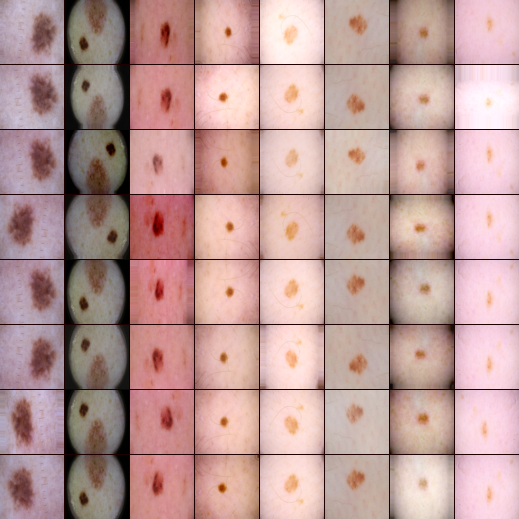

In [23]:
row = 8; col = 8;
#row = min(row,BATCH_SIZE//col)

all_elements = (
    tf.data.Dataset
    .from_tensor_slices((train_paths_fold_0, train_labels_fold_0))
    .shuffle(2048)
    .take(row)
    .cache()
    .repeat(row*col)
    .map(decode_jpg_image, num_parallel_calls=AUTO))

augmented_element = all_elements.map(augment_jpg_image, num_parallel_calls=AUTO).prefetch(AUTO)

size = 64
it = iter (augmented_element)
img = Image.new(mode='RGB', size=(col*size+col-1, row*size+row-1), color=30)
for i in range(col*row):    
    (img2, label) = next(it)
    img2 = img2*255
    img2 = tf.clip_by_value(img2, clip_value_min=0, clip_value_max=255)
    ix = i % col
    iy= i // col
    img1 = Image.fromarray(cv2.cvtColor(img2.numpy(),cv2.COLOR_BGR2RGB).astype(np.uint8))
    img1 = img1.resize((size, size), resample=PIL.Image.BILINEAR)
    img.paste(img1, (ix*size+ix, iy*size+iy))
        
display(img)

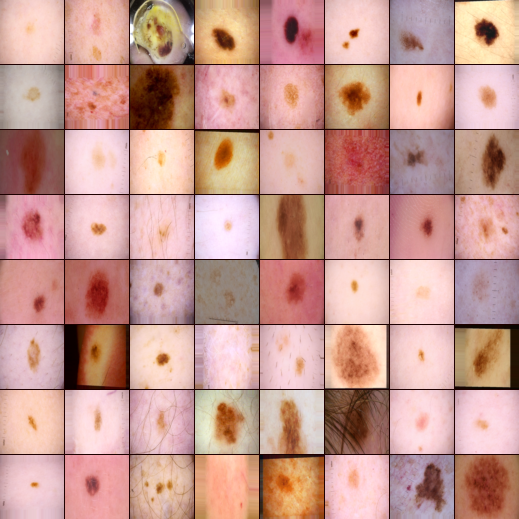

In [24]:
size = 64
(img_batch,lbl_batch) = next(iter(train_dataset_fold_0))
row = img_batch.shape[0]//col
img = Image.new(mode='RGB', size=(col*size+col-1, row*size+row-1), color=30)
for i in range(row*col):    
    (img2, label) = (img_batch[i],lbl_batch[i])
    img2 = img2*255
    img2 = tf.clip_by_value(img2, clip_value_min=0, clip_value_max=255)
    ix = i % col
    iy= i // col
    img1 = Image.fromarray(cv2.cvtColor(img2.numpy(),cv2.COLOR_BGR2RGB).astype(np.uint8))
    img1 = img1.resize((size, size), resample=PIL.Image.BILINEAR)
    img.paste(img1, (ix*size+ix, iy*size+iy))
        
display(img)

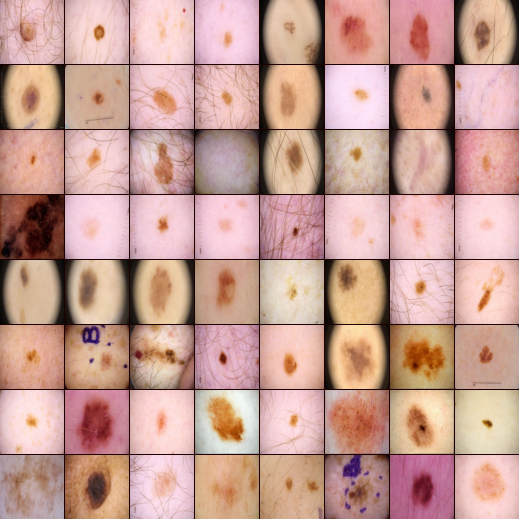

In [25]:
size = 64
imgs=next(iter(test_dataset.take(size)))
row = imgs.shape[0]//col
img = Image.new(mode='RGB', size=(col*size+col-1, row*size+row-1), color=30)
for i in range(row*col):    
    img2= imgs[i]*255
    img2 = tf.clip_by_value(img2, clip_value_min=0, clip_value_max=255)
    ix = i % col
    iy= i // col
    img1 = Image.fromarray(cv2.cvtColor(img2.numpy(),cv2.COLOR_BGR2RGB).astype(np.uint8))
    img1 = img1.resize((size, size), resample=PIL.Image.BILINEAR)
    img.paste(img1, (ix*size+ix, iy*size+iy))
        
display(img)

In [26]:
with strategy.scope():
        #SEResnext50, preprocess_input = Classifiers.get('seresnext50')
        model = tf.keras.Sequential([
            #SEResnext50((*IMAGE_SIZE, 3),weights='imagenet',include_top=False),                        
            efn.EfficientNetB0(
               input_shape=(*IMAGE_SIZE, 3),
               weights='noisy-student',
                include_top=False),
            L.GlobalAveragePooling2D(),
            L.Dense(1, activation='sigmoid')
        ])
        
        opt=tf.keras.optimizers.Adam(learning_rate=0.001)
        #checkpoint =  tf.train.Checkpoint(latest_epoch=tf.Variable(0), optimizer=opt, model=model)
        #chkp_manager =  tf.train.CheckpointManager(checkpoint, CHKP_DIR, max_to_keep=3)
        #print(chkp_manager.latest_checkpoint)

        #chkp_restore_status=checkpoint.restore(chkp_manager.latest_checkpoint)
        #if chkp_manager.latest_checkpoint:
          #chkp_restore_status.assert_consumed()
          #print("Restored from {}".format(chkp_manager.latest_checkpoint))
          #print(f"Lastest epoch {checkpoint.latest_epoch.numpy()}")
        #else:
          #print("Initializing from scratch.")

        model.compile(
            optimizer=opt,
            loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = LABEL_SMOOTH_FACTOR),
            metrics=[tf.keras.metrics.AUC(name='roc_auc')]
        )

16703488/16696600 [==============================] - 0s 0us/step
None
Initializing from scratch.


In [35]:
model.save(CHKP_DIR+'model.h5')

In [36]:
chkp_manager =  tf.train.CheckpointManager(checkpoint, GCS_SHON_PATH, max_to_keep=3)

In [37]:
chkp_manager.save()

PermissionDeniedError: ignored

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 16, 16, 1280)      4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 42,016
_________________________________________________________________


In [ ]:
def build_lrfn(lr_start=0.001, lr_max=0.001, 
               lr_min=0.0001, lr_rampup_epochs=0, 
               lr_sustain_epochs=0, lr_exp_decay=.8):
    #lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn
lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1)

In [ ]:
class KaggleValidation_melanoma(Callback):
    
    def __init__(self, valid_ds,val_y_true,test_ds,train_steps, vals_per_epoch=1, logfile=None, initial_epoch=0,suffix=None,
                 output_dir='./',cv_threshold=0.9,chkp_manager=None):
        super().__init__()
        self.valid_ds = valid_ds
        self.valid_y_true = val_y_true
        self.test_ds = test_ds
        self.current_epoch = initial_epoch
        self.num_batches = train_steps
        self.val_steps = train_steps//vals_per_epoch
        self.logfile = logfile
        self.best_cv_auc = cv_threshold
        self.suffix = suffix
        self.output_dir = output_dir
        self.chkp_manager = chkp_manager
       
    def do_savelog(self):
        log_df = pd.DataFrame()
        log_df['epoch']=self.iters
        log_df['lr']=self.lr_values
        log_df['train_loss']=self.train_losses
        log_df['val_loss']=self.val_losses
        log_df['train_rocauc']=self.train_rocaucs
        log_df['val_rocauc']=self.val_rocaucs
        log_df['time']=self.time_stamp
        log_df.to_csv(self.logfile, index=False, float_format='%.6f')
      
    def do_validation(self,num_iter=0, logs={}):
        val_y_scores = self.model.predict(self.valid_ds, verbose=1)
        val_rocauc = roc_auc_score(self.valid_y_true,val_y_scores)
        val_loss = log_loss(self.valid_y_true, val_y_scores)
        loc_time = math.floor(time.time()-self.time_start)
        print(f'[{str(datetime.timedelta(seconds=loc_time))}] - val_rocauc:{val_rocauc:.4f}')
        self.val_losses.append(val_loss)
        self.val_rocaucs.append(val_rocauc)
        self.time_stamp.append(str(datetime.timedelta(seconds=loc_time)))
        self.iters.append(num_iter)
        self.train_losses.append(logs.get('loss'))
        self.train_rocaucs.append(logs.get('roc_auc'))
        self.lr_values.append(K.get_value(self.model.optimizer.lr))

        if self.logfile != None: self.do_savelog()

        if val_rocauc>self.best_cv_auc:
            self.best_cv_auc = val_rocauc
            print(f'saving submission with cv auc {self.best_cv_auc}...')
            probs = self.model.predict(self.test_ds, verbose=1)
            sub['target']=probs
            sub.to_csv(self.output_dir+f'sub_cv_{self.best_cv_auc:.4f}_'+self.suffix+'.csv', index=False)
            #self.model.save_weights(self.output_dir+f'w_cv_{self.best_cv_auc:.4f}_'+self.suffix+'.h5')
  
    def on_train_begin(self, logs={}):
        self.val_rocaucs = []
        self.train_rocaucs =[]
        self.time_stamp = []
        self.iters = []
        self.time_start = time.time()
        self.train_losses = []
        self.val_losses = []
        self.lr_values = []
        
    def on_batch_end(self,batch,logs={}):
        if batch%self.val_steps == self.val_steps-1: 
            print(f'\nbatch {batch}: validation...')
            num_iter = self.current_epoch + batch/self.num_batches
            self.do_validation(num_iter=num_iter,logs=logs)
            gc.collect()
    
    def on_epoch_end(self, epoch, logs={}):
        self.current_epoch +=1
        logs['kaggle']=self.val_rocaucs[len(self.val_rocaucs)-1]
        if self.chkp_manager !=None:
            self.chkp_manager._checkpoint.latest_epoch.assign_add(1)
            save_path=self.chkp_manager.save()
            print("\nsaved checkpoint for epoch {}: {}\n".format(int(self.chkp_manager._checkpoint.latest_epoch), save_path))

In [ ]:
initial_epoch=checkpoint.latest_epoch.numpy()
print(f'epochs trained: {initial_epoch}. start training epoch {initial_epoch+1}...')

epochs trained: 0. start training epoch 1...


In [ ]:
suffix =EXPERIMENT+\
                '_eps'+str(EPOCHS)+\
                '_iniep'+str(initial_epoch)+\
                '_sz'+str(IMG_SIZE)+\
                '_bs'+str(BATCH_SIZE)+\
                '_do'+str(DROP_OUT)+\
                '_'+model.optimizer.get_config()['name']+\
                '_IS_fold'+str(FOLD)

kv = KaggleValidation_melanoma(valid_dataset_fold_0,
                               val_labels_fold_0,
                               test_dataset,
                               vals_per_epoch=50,
                               train_steps=len(train_paths_fold_0)//BATCH_SIZE+1,
                               logfile=EXPERIMENT_DIR+'log_'+suffix+'.csv',
                               initial_epoch=initial_epoch,
                               suffix = suffix,
                               output_dir=EXPERIMENT_DIR,
                               cv_threshold=0.9,
                               chkp_manager=None)

In [ ]:


STEPS_PER_EPOCH = len(train_paths_fold_0) // BATCH_SIZE
history = model.fit(
        train_dataset_fold_0, 
        epochs=EPOCHS, 
        callbacks=[lr_schedule,kv],
        steps_per_epoch=STEPS_PER_EPOCH,
        verbose=2
    )


Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.
Epoch 1/15

batch 13: validation...
183/183 [==============================] - 390s 2s/step
[0:08:59] - val_rocauc:0.6746

batch 27: validation...
183/183 [==============================] - 10s 56ms/step
[0:09:24] - val_rocauc:0.5888

batch 41: validation...
183/183 [==============================] - 10s 57ms/step
[0:09:55] - val_rocauc:0.5708

batch 55: validation...
183/183 [==============================] - 10s 57ms/step
[0:10:27] - val_rocauc:0.5980

batch 69: validation...
183/183 [==============================] - 11s 59ms/step
[0:11:01] - val_rocauc:0.5721

batch 83: validation...
183/183 [==============================] - 10s 57ms/step
[0:11:32] - val_rocauc:0.5791

batch 97: validation...
183/183 [==============================] - 10s 57ms/step
[0:12:03] - val_rocauc:0.5495

batch 111: validation...
183/183 [==============================] - 10s 57ms/step
[0:12:32] - val_rocauc:0.5824

batch 125: validation..

UnimplementedError: ignored

In [ ]:
def display_training_curves(training, validation, title, subplot):
    """
    Source: https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu
    """
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('iters')
    ax.legend(['train', 'valid.'])

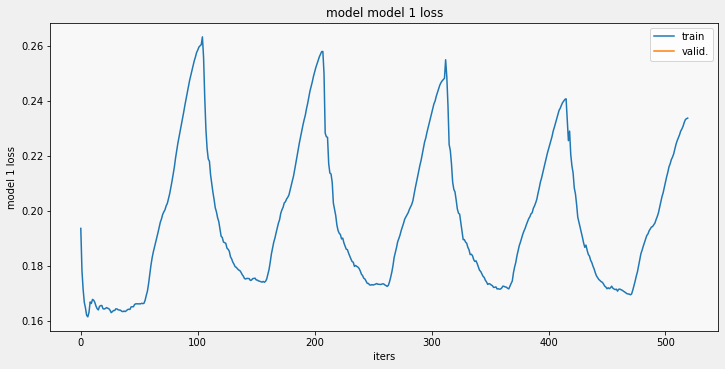

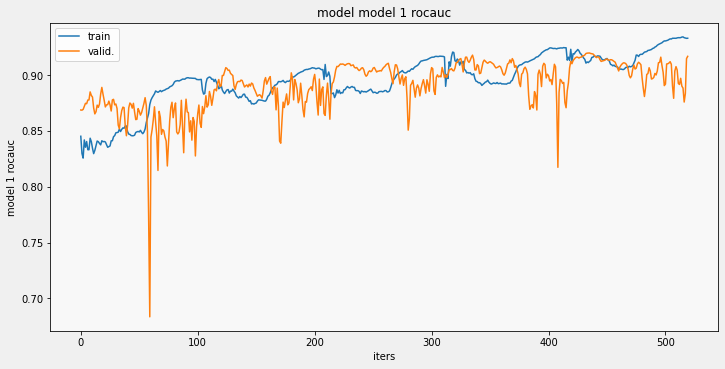

In [ ]:
display_training_curves(
        kv.train_losses, 
        kv.val_losses, 
        'model 1 loss', 211)

display_training_curves(
        kv.train_rocaucs, 
        kv.val_rocaucs, 
        'model 1 rocauc', 211)

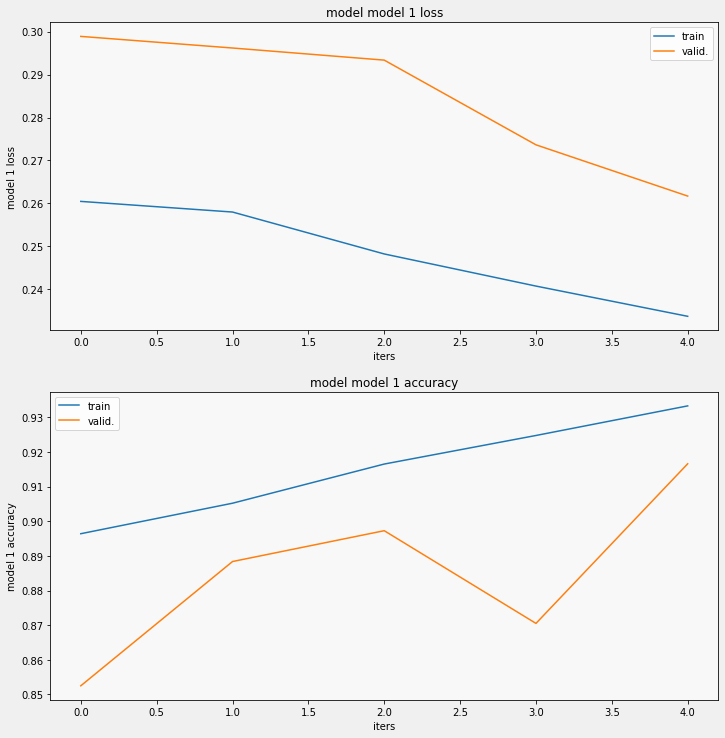

In [ ]:
display_training_curves(
        history.history['loss'], 
        history.history['val_loss'], 
        'model 1 loss', 211)

display_training_curves(
        history.history['roc_auc'], 
        history.history['val_roc_auc'], 
        'model 1 accuracy', 212)